# Summary of fragmentomics features in FinaleTools
This figure presents a precise summary of all of the fragmentomics features that can be calculated using the FinaleTools package and command line program.

### Features to Represent
- Fragment Coverage
- Fragment Lengths
- Window Protection Score (WPS)
- DNA evaluation of fragments for early interception (DELFI)
- End motifs
- Motif Diversity Score (MDS)

In [37]:
# imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy.stats as stats
import gzip
from statsmodels.regression.linear_model import OLS

## Window Protection Score

In [2]:
# Window Protection Score
ft_wps = []
with open("../data/BH01.chr12_asat.LWPS.raw.bedGraph", 'r') as ft_wps_file:
    for line in ft_wps_file:
        contents = line.split()
        ft_wps.append((contents[0], int(contents[1]), int(contents[2]), float(contents[3])))

shendure_wps = []
with gzip.open('../data/shendure.BH01.chr12.asat.wps.wig.gz', 'rt') as shendure_file:
    lines = shendure_file.readlines()
    header = lines[0].split()
    chrom = header[1].split('=')[1][3:]
    start = int(header[2].split('=')[1])
    step = int(header[3].split('=')[1])
    pos = start
    for line in lines[1:]:
        score = float(line)
        shendure_wps.append((chrom, pos, pos+1, score))
        pos += 1
ft_wps = np.array(ft_wps, dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('score', '<f8')])
shendure_wps = np.array(shendure_wps, dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('score', '<f8')])
ft_wps, shendure_wps

(array([('12', 34442000, 34442001, -24.), ('12', 34442001, 34442002, -24.),
        ('12', 34442002, 34442003, -26.), ...,
        ('12', 34446997, 34446998, -23.), ('12', 34446998, 34446999, -24.),
        ('12', 34446999, 34447000, -24.)],
       dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('score', '<f8')]),
 array([('12', 34442000, 34442001, -52.), ('12', 34442001, 34442002, -49.),
        ('12', 34442002, 34442003, -51.), ...,
        ('12', 34446998, 34446999, -62.), ('12', 34446999, 34447000, -64.),
        ('12', 34447000, 34447001, -61.)],
       dtype=[('chrom', '<U16'), ('start', '<i8'), ('stop', '<i8'), ('score', '<f8')]))

In [3]:
# Get stats
pearson, _ = stats.pearsonr(ft_wps['score'], shendure_wps['score'][:-1])
spearman, _ = stats.spearmanr(ft_wps['score'], shendure_wps['score'][:-1])

pearson, spearman

(0.9348921380863161, 0.9362639734208263)

In [29]:
# Regression line
ols = OLS(shendure_wps['score'][:-1], ft_wps['score'])
model = ols.fit()
regression = model.predict(ft_wps['score'])
r2 = model.rsquared_adj
r2

0.9732501042161789

Text(-15, -80, "$R^2=0.9733$\nPearson's $\\rho = 0.9349$\nSpearman's $r = 0.9363$\n")

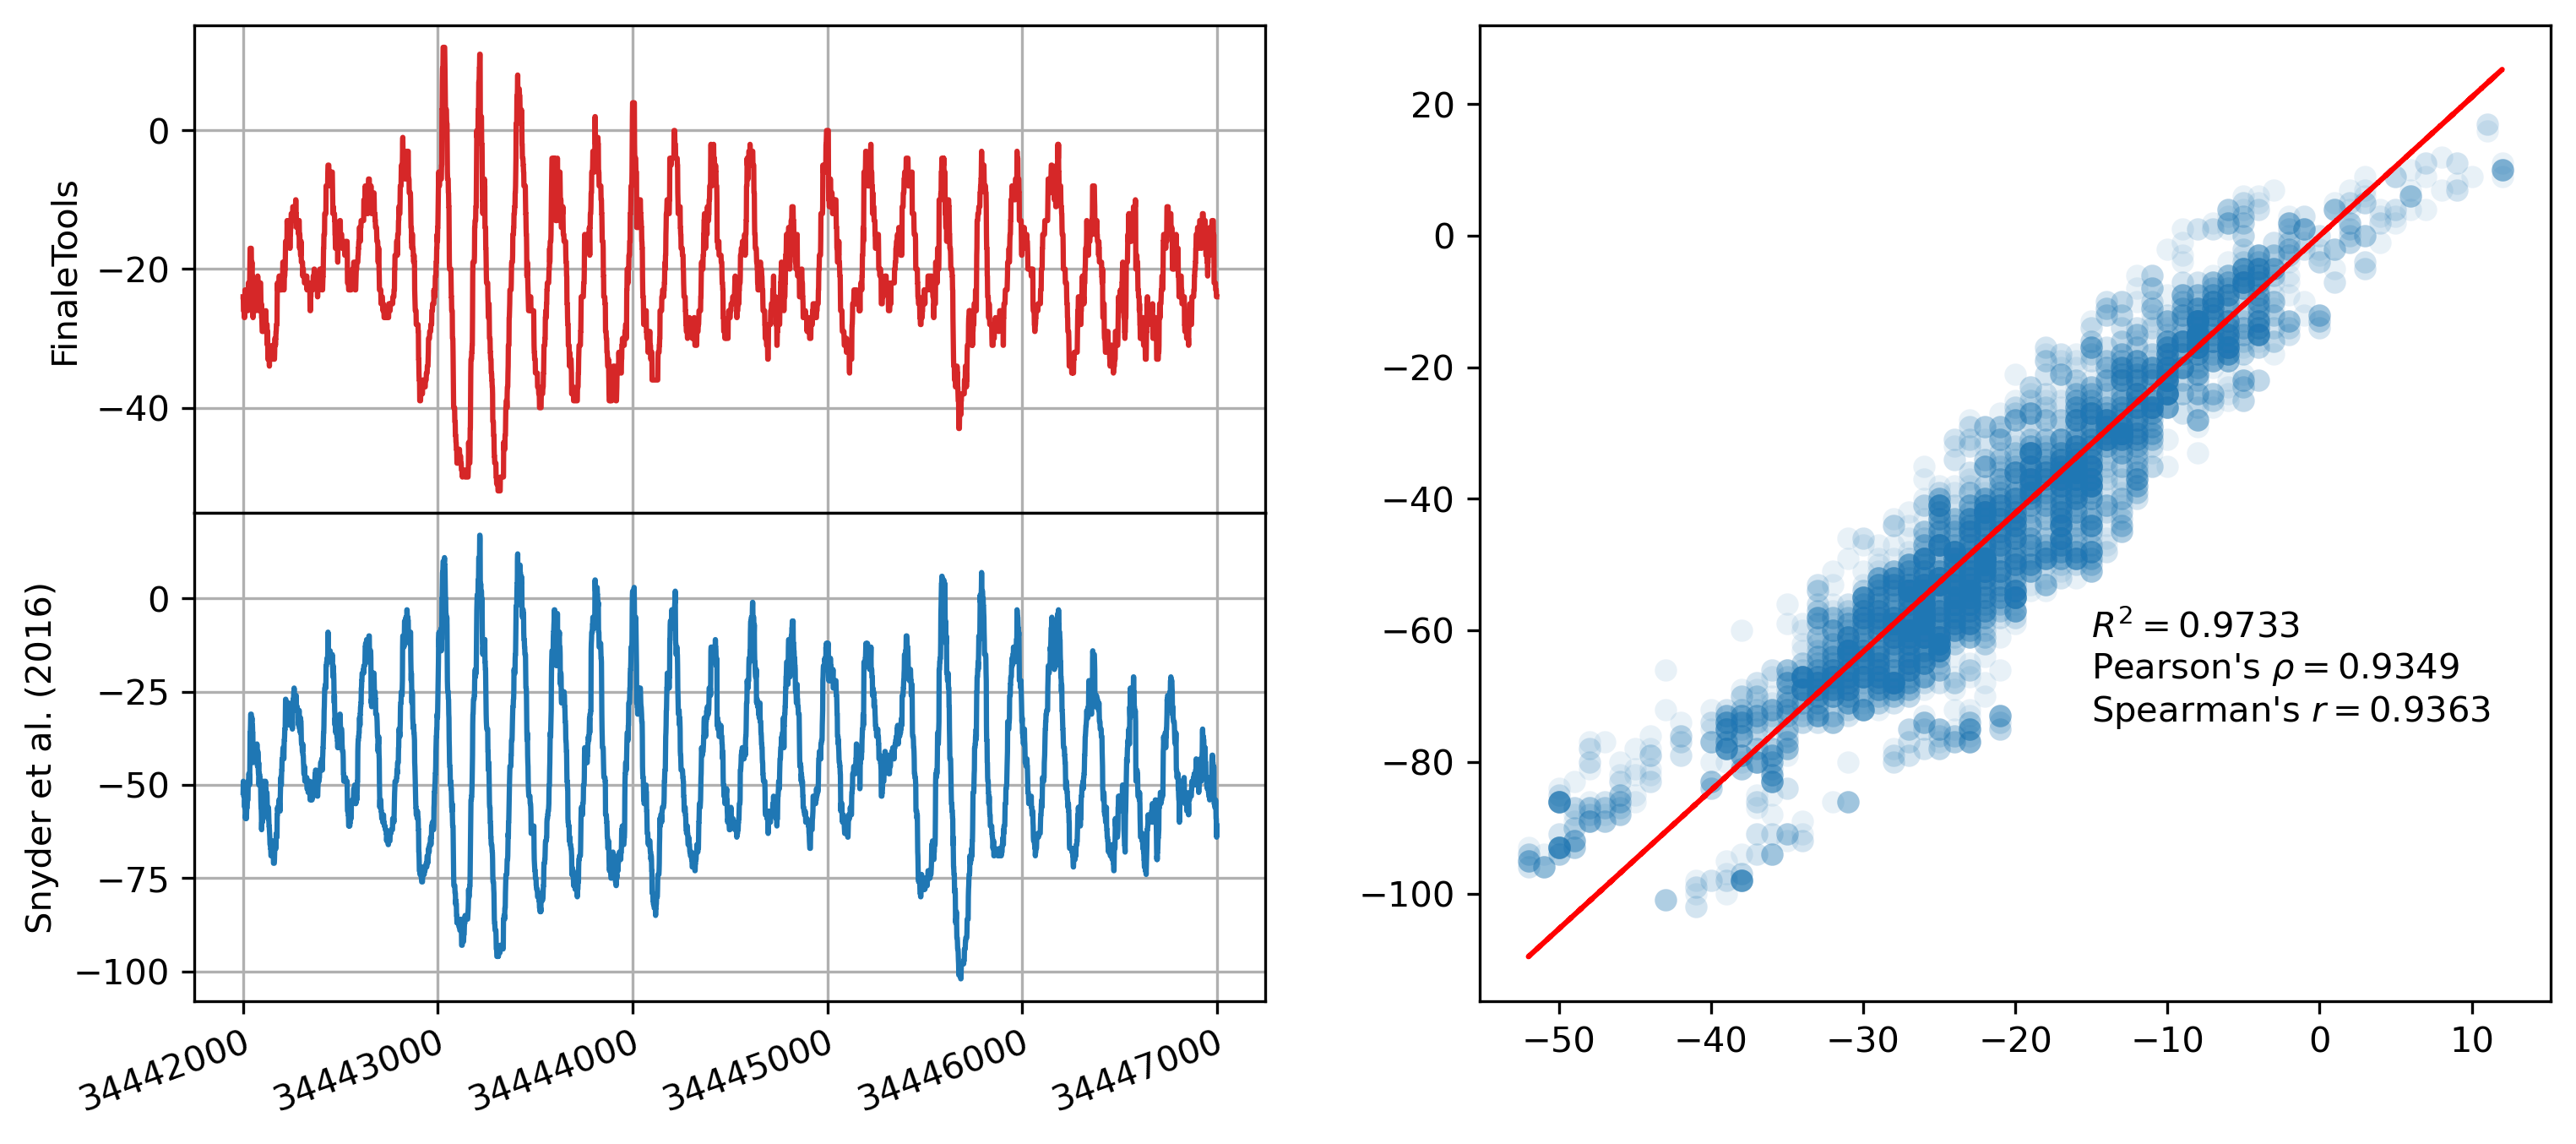

In [52]:
# plotting comparison
fig, axes = plt.subplots(2, 2, sharex=True)
fig.set_dpi(300)
fig.set_size_inches(12, 5)
axes[0, 0].plot(ft_wps['start'], ft_wps['score'], 'C3', label="FinaleTools")
axes[0, 0].set_ylabel('FinaleTools')
axes[1, 0].plot(shendure_wps['start'], shendure_wps['score'], 'C0', label="Snyder et al. (2016)")
axes[1, 0].set_ylabel('Snyder et al. (2016)')

plt.setp(axes[1, 0].get_xticklabels(), rotation=20, ha="right",
         rotation_mode="anchor")
x_formatter = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=False)
x_formatter.set_scientific(False)

fig.subplots_adjust(hspace=0)

axes[1, 0].xaxis.set_major_formatter(x_formatter)
axes[0, 0].grid()
axes[1, 0].grid()

gs = axes[0, 1].get_gridspec()
for ax in axes[:, 1]:
    ax.remove()

scatter_ax = fig.add_subplot(gs[:, 1])
scatter_ax.scatter(ft_wps['score'], shendure_wps['score'][:-1], s=40, alpha=0.1, linewidths=0)
scatter_ax.plot(ft_wps['score'], regression, 'r--')
stats_string = f"""$R^2={r2:.4f}$
Pearson's $\\rho = {pearson:.4f}$
Spearman's $r = {spearman:.4f}$
"""
scatter_ax.text(-15, -80, stats_string)


## End-motifs

In [130]:
# read data from csv. The csv is our end-motif calculations on a dataset
# from Jiang et al (2015), which is different from the data used in 
# Jiang et al (2020).
end_motifs_csv = pd.read_csv('../data/jiang_end_motifs.csv')
end_motifs_csv

,id,disease,MDS,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
0,85754,Hepatitis B,0.947460,0.012309,0.003738,0.006359,0.006675,0.003998,0.001974,0.000456,...,0.000261,0.002243,0.003011,0.001322,0.001604,0.002290,0.004639,0.003722,0.003159,0.008290
1,85755,Hepatitis B,0.948628,0.012077,0.003751,0.006580,0.006676,0.003997,0.001924,0.000466,...,0.000322,0.002092,0.002940,0.001319,0.001736,0.002278,0.004382,0.003386,0.003076,0.007737
2,85756,Healthy,0.947818,0.012095,0.003881,0.006557,0.006915,0.004198,0.002054,0.000437,...,0.000248,0.002178,0.002818,0.001217,0.001545,0.002210,0.004554,0.003485,0.002981,0.008111
3,85757,Healthy,0.950109,0.011941,0.003605,0.006562,0.006492,0.003823,0.001873,0.000430,...,0.000304,0.002455,0.003216,0.001450,0.002169,0.002502,0.004502,0.003589,0.003322,0.008234
4,85758,Cirrhosis,0.949890,0.012812,0.003775,0.006617,0.006977,0.004038,0.001953,0.000439,...,0.000296,0.002417,0.003096,0.001405,0.001933,0.002430,0.004604,0.003669,0.003274,0.008563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,85998,Cirrhosis,0.948422,0.012595,0.003991,0.006556,0.007274,0.004392,0.002116,0.000464,...,0.000232,0.001880,0.002474,0.001071,0.001256,0.001996,0.004306,0.003306,0.002767,0.008187
221,85999,Hepatitis B,0.947610,0.012180,0.003946,0.006548,0.006973,0.004191,0.002122,0.000459,...,0.000248,0.001993,0.002769,0.001211,0.001428,0.002133,0.004449,0.003701,0.002985,0.008199
222,86000,Liver cancer,0.948147,0.011252,0.003609,0.006021,0.006292,0.003931,0.001946,0.000429,...,0.000285,0.002083,0.002810,0.001347,0.001618,0.002230,0.004342,0.003514,0.003072,0.007945
223,86001,Hepatitis B,0.946225,0.012559,0.003930,0.006537,0.007063,0.004245,0.002123,0.000442,...,0.000252,0.002041,0.002753,0.001203,0.001402,0.002156,0.004531,0.003560,0.002986,0.008170


In [131]:
# get mds for Healthy, HBV, and HCC
# NOTE: this dataset was retrived from FinaleDB, which uses the 'Liver
# cancer' label for some samples. Jiang et al (2015) makes no mention of
# non-HCC liver cancers in their patients, so it is assumed that all
# samples labled 'Liver cancer' are also HCC.
healthy_mds = end_motifs_csv.loc[end_motifs_csv['disease']=='Healthy', 'MDS']
hbv_mds = end_motifs_csv.loc[end_motifs_csv['disease']=='Hepatitis B', 'MDS']
hcc_mds = end_motifs_csv.loc[end_motifs_csv['disease']=='Liver cancer', 'MDS']
mds_series = [healthy_mds, hbv_mds, hcc_mds]
healthy_mds

2      0.947818
3      0.950109
16     0.948231
21     0.948784
28     0.949690
31     0.947967
35     0.948267
39     0.949250
57     0.948971
68     0.948383
80     0.949486
90     0.947895
96     0.949448
97     0.948442
114    0.947831
132    0.948711
138    0.948072
139    0.949467
142    0.947913
149    0.948251
159    0.951082
165    0.948665
166    0.949700
170    0.951841
186    0.948554
190    0.947981
197    0.948431
198    0.948068
204    0.948276
209    0.949581
211    0.949520
212    0.948110
Name: MDS, dtype: float64

In [132]:
# Get motif freqs of non-HCC and HCC patients for six motifs of interest
# for HCC
motifs = ['CCCA', 'CCAG', 'CCTG', 'TAAA', 'AAAA', 'TTTT']

# motif-freqs are stored in DataFrames in a list. For each motif there
# is a DataFrame for Non-HCC and a DataFrame for HCC

motif_freq_list = []
for motif in motifs:
    non_hcc = end_motifs_csv.loc[(end_motifs_csv['disease']=='Healthy')|(end_motifs_csv['disease']=='Hepatitis B'), motif]
    hcc = end_motifs_csv.loc[end_motifs_csv['disease']=='Liver cancer', motif]
    motif_freq_list.append(non_hcc)
    motif_freq_list.append(hcc)
motif_freq_list[1]

# box plot positions, colors, x tick labels
colors = []
positions = []
labels = []
ticks = []
tick_labels = []
for i in range(len(motifs)):
    positions.append(3*i+1)
    positions.append(3*i+2)
    ticks.append(3*i+1.5)
    tick_labels.append(motifs[i])
    colors.append('C0')
    colors.append('C3')
    labels.append('Non-HCC')
    labels.append('HCC')

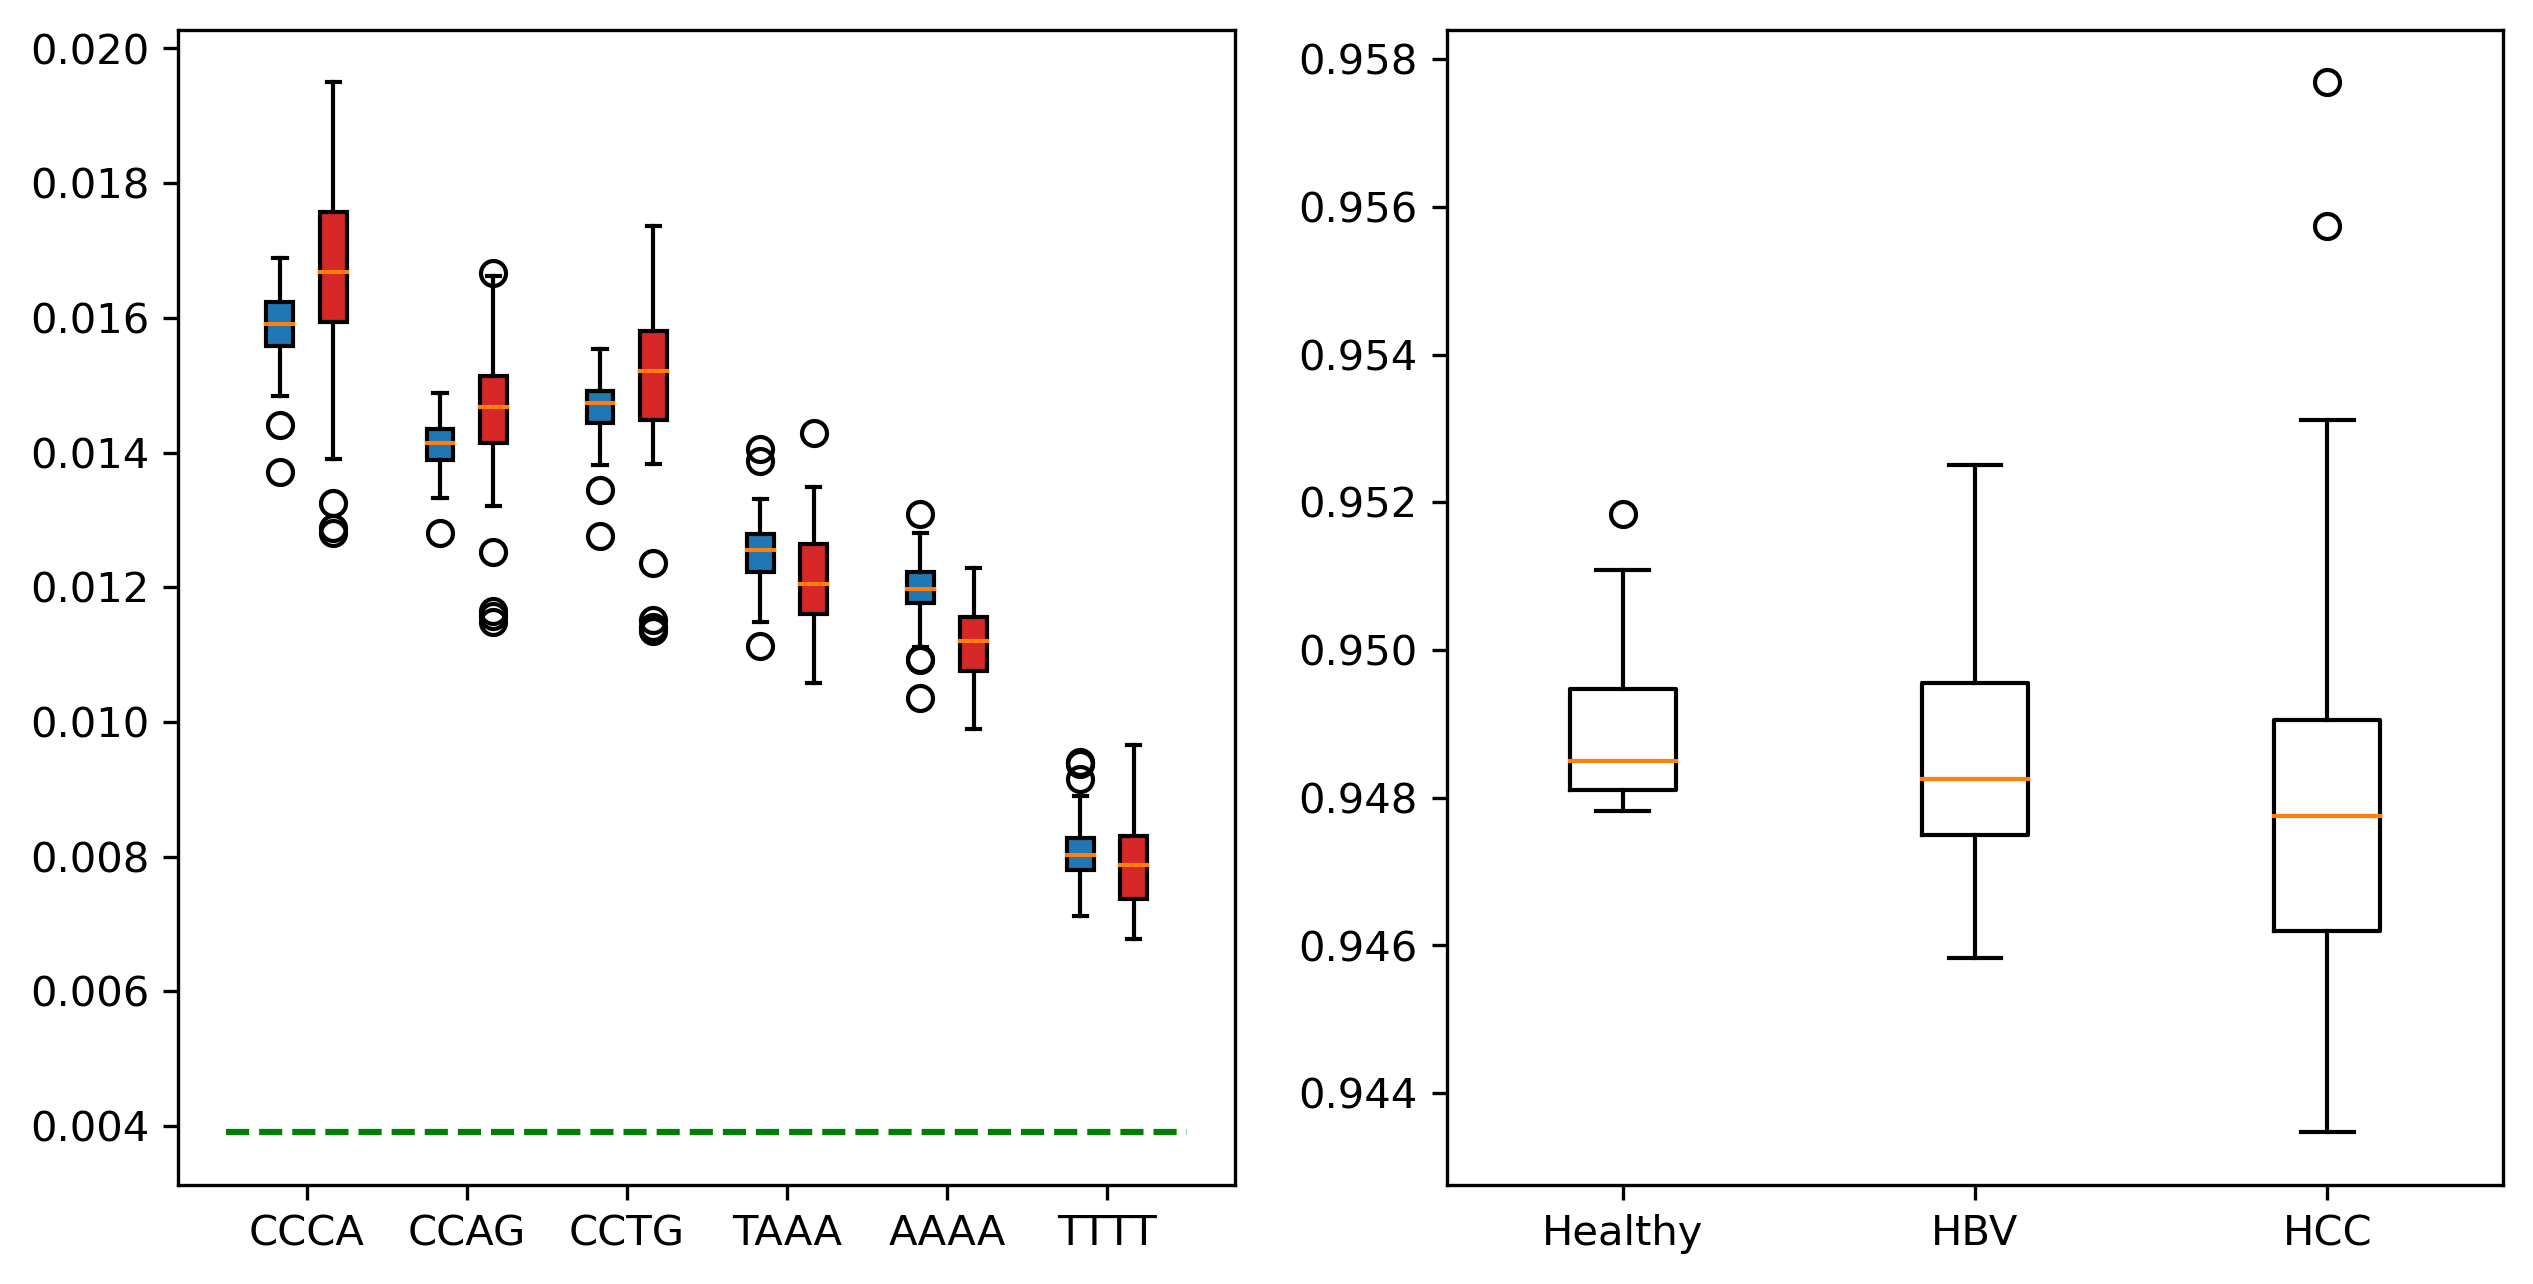

In [133]:
# plotting
fig, axes = plt.subplots(1, 2)
fig.set_dpi(300)
fig.set_size_inches(10, 5)

# Box plot for HCC motifs
motif_box_plot = axes[0].boxplot(
        motif_freq_list,
        labels=labels,
        positions=positions,
        patch_artist=True,
)
for patch, color in zip(motif_box_plot['boxes'], colors):
        patch.set_facecolor(color)
axes[0].plot([0, 18], [1/256, 1/256], 'g--')
axes[0].set_xticks(ticks, tick_labels)
# FIXME: add legend

# Box plot for MDS
mds_box_plot = axes[1].boxplot(
        mds_series,
)
axes[1].set_xticks([1, 2, 3], ['Healthy', 'HBV', 'HCC'])

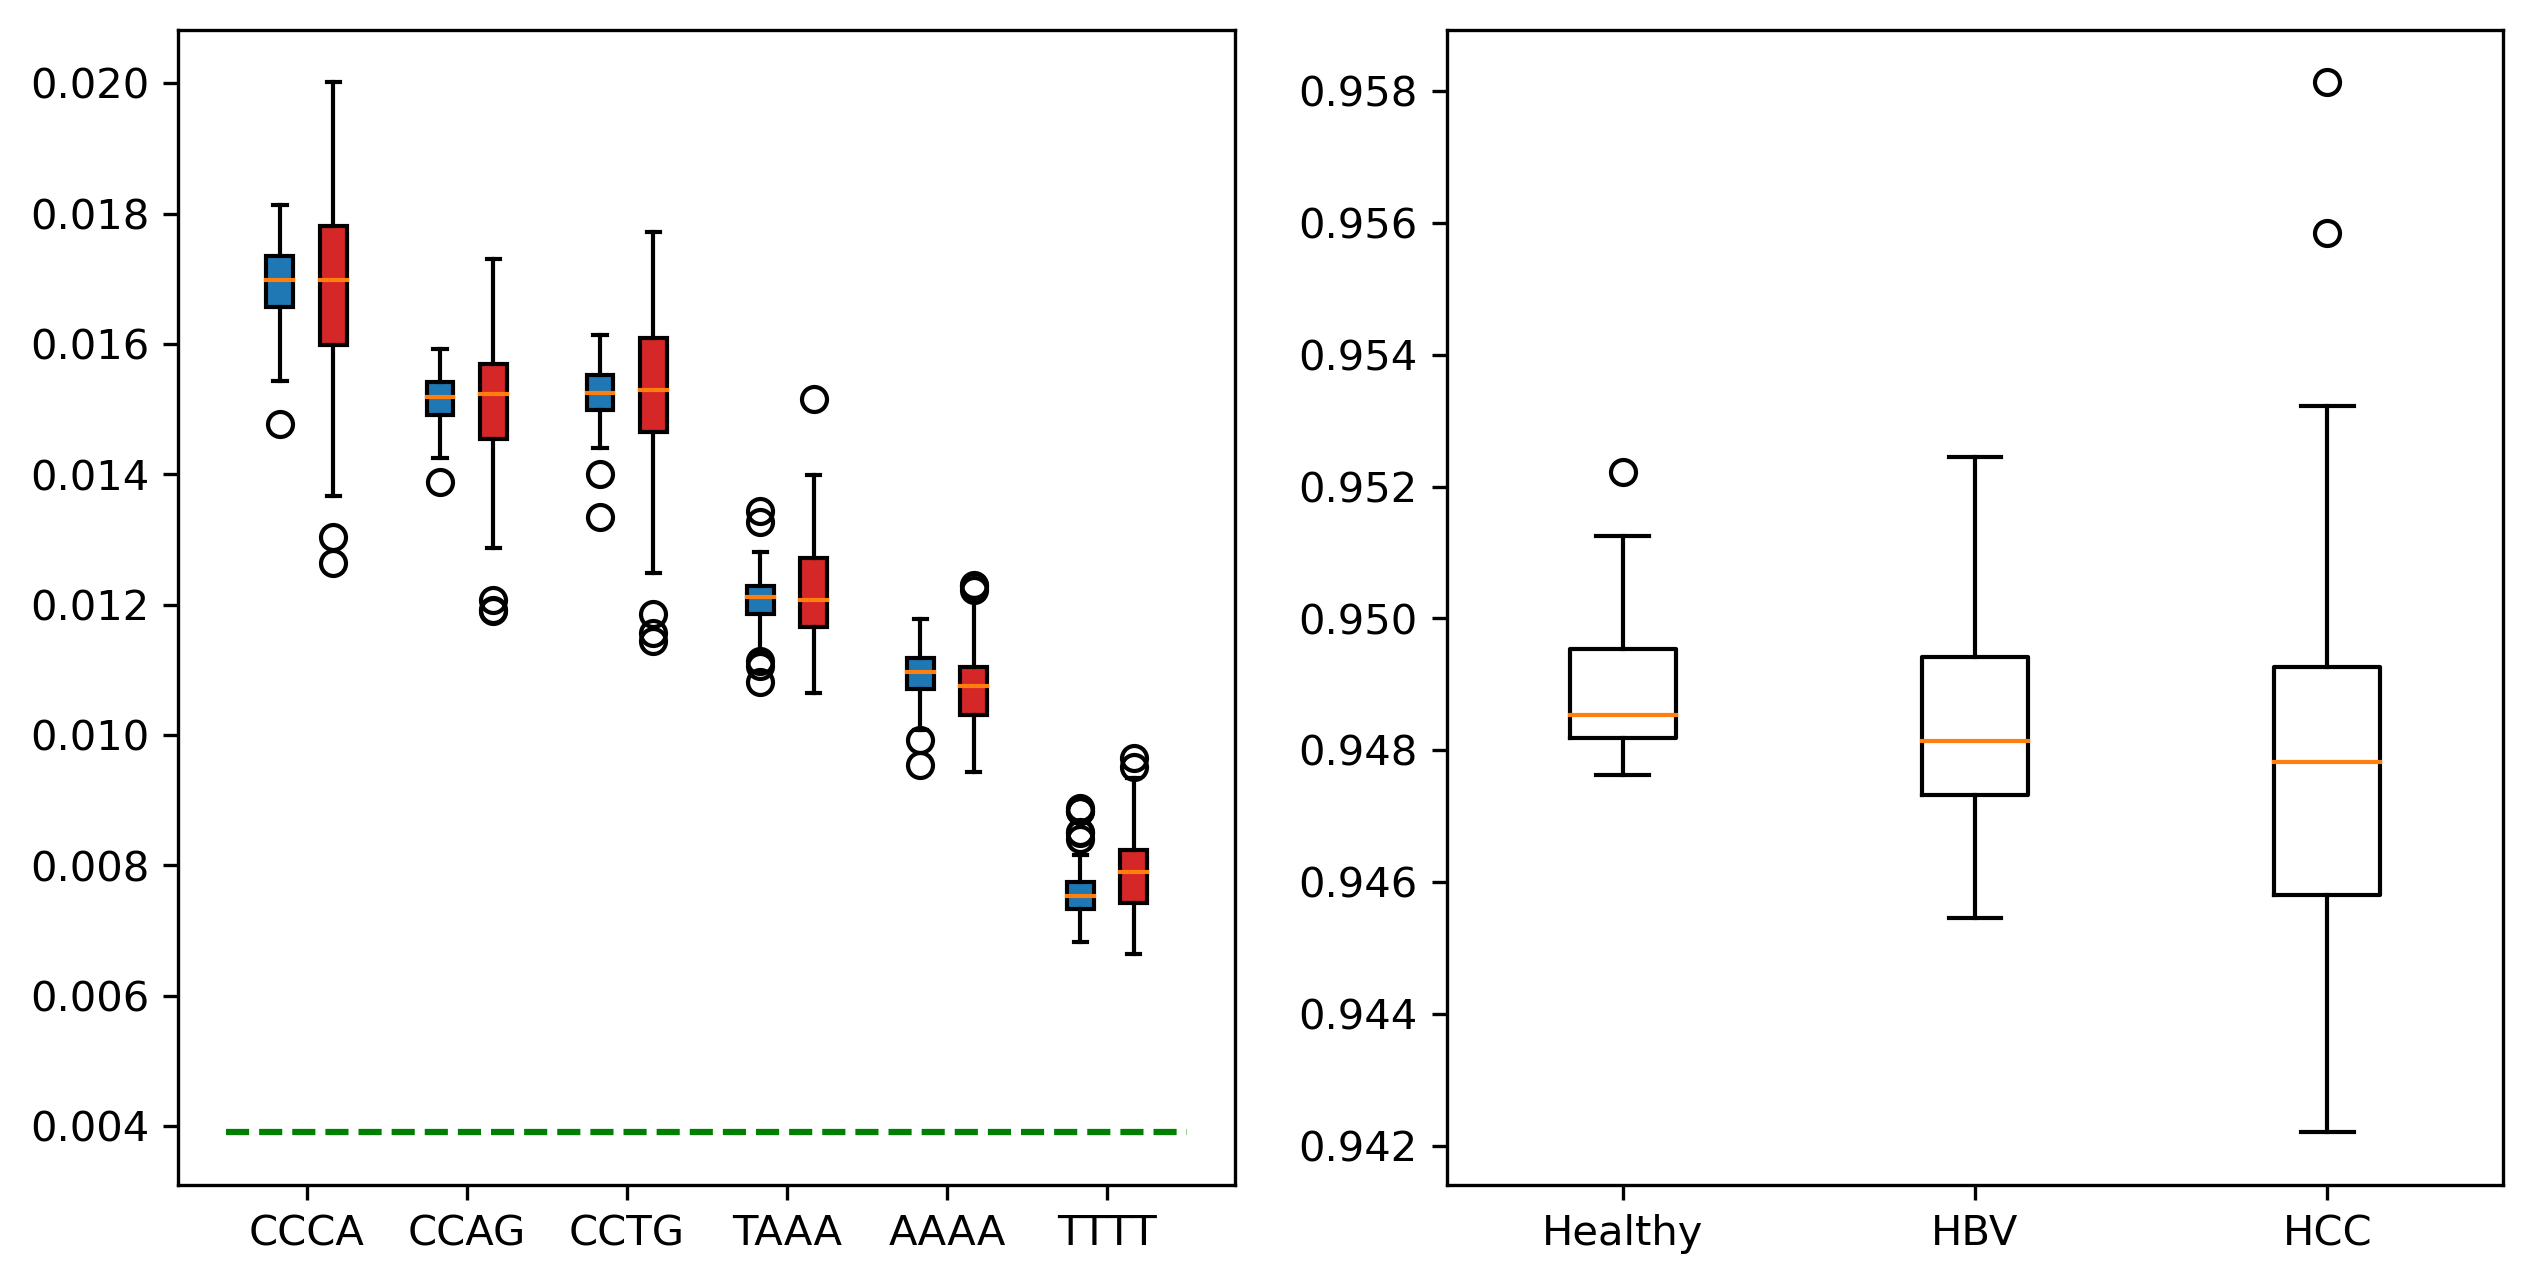

In [134]:
# read data from csv. The csv is our end-motif calculations on a dataset
# from Jiang et al (2015), which is different from the data used in 
# Jiang et al (2020).
end_motifs_csv = pd.read_csv('../../Desktop/jiang_end_motifs_Jul26.csv')
end_motifs_csv
# get mds for Healthy, HBV, and HCC
# NOTE: this dataset was retrived from FinaleDB, which uses the 'Liver
# cancer' label for some samples. Jiang et al (2015) makes no mention of
# non-HCC liver cancers in their patients, so it is assumed that all
# samples labled 'Liver cancer' are also HCC.
healthy_mds = end_motifs_csv.loc[end_motifs_csv['disease']=='Healthy', 'mds']
hbv_mds = end_motifs_csv.loc[end_motifs_csv['disease']=='Hepatitis B', 'mds']
hcc_mds = end_motifs_csv.loc[end_motifs_csv['disease']=='Liver cancer', 'mds']
mds_series = [healthy_mds, hbv_mds, hcc_mds]
healthy_mds
# Get motif freqs of non-HCC and HCC patients for six motifs of interest
# for HCC
motifs = ['CCCA', 'CCAG', 'CCTG', 'TAAA', 'AAAA', 'TTTT']

# motif-freqs are stored in DataFrames in a list. For each motif there
# is a DataFrame for Non-HCC and a DataFrame for HCC

motif_freq_list = []
for motif in motifs:
    non_hcc = end_motifs_csv.loc[(end_motifs_csv['disease']=='Healthy')|(end_motifs_csv['disease']=='Hepatitis B'), motif]
    hcc = end_motifs_csv.loc[end_motifs_csv['disease']=='Liver cancer', motif]
    motif_freq_list.append(non_hcc)
    motif_freq_list.append(hcc)
motif_freq_list[1]

# box plot positions, colors, x tick labels
colors = []
positions = []
labels = []
ticks = []
tick_labels = []
for i in range(len(motifs)):
    positions.append(3*i+1)
    positions.append(3*i+2)
    ticks.append(3*i+1.5)
    tick_labels.append(motifs[i])
    colors.append('C0')
    colors.append('C3')
    labels.append('Non-HCC')
    labels.append('HCC')
# plotting
fig, axes = plt.subplots(1, 2)
fig.set_dpi(300)
fig.set_size_inches(10, 5)

# Box plot for HCC motifs
motif_box_plot = axes[0].boxplot(
        motif_freq_list,
        labels=labels,
        positions=positions,
        patch_artist=True,
)
for patch, color in zip(motif_box_plot['boxes'], colors):
        patch.set_facecolor(color)
axes[0].plot([0, 18], [1/256, 1/256], 'g--')
axes[0].set_xticks(ticks, tick_labels)
# FIXME: add legend

# Box plot for MDS
mds_box_plot = axes[1].boxplot(
        mds_series,
)
axes[1].set_xticks([1, 2, 3], ['Healthy', 'HBV', 'HCC'])